# IMPORT LIBRARIES

In [1]:
import sys
import random
import torch
import numpy as np
from pathlib import Path
sys.path.append(str(Path("../").resolve()))
import json
import matplotlib.pyplot as plt
import pandas as pd
from experiments.ablation_history import run_ablation_history

# SET FILE PATH & PARAMETERS

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(11)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

Device: cpu


In [3]:
# Get the data folder
processed_folder = "../data"
data_file = "era5_1960to2020_17feats_processed.npz"
data_path = f"{processed_folder}/{data_file}"

# Specify parameters for ablation study
# This study looks at the change in history window (T)
T_values = [1, 3, 5, 7, 14, 30]
horizon = 3
lstm_epochs = 40
transformer_epochs = 40

output_dir = "ablation_outputs"

# RUN ABLATION STUDY

In [4]:
results = run_ablation_history(
    data_path=data_path,
    T_values=T_values,
    horizon=horizon,
    lstm_epochs=lstm_epochs,
    transformer_epochs=transformer_epochs,
    device=DEVICE,
    save_results=True,
    save_curves=True,
    output_dir=output_dir
)

results


Running ablation for history window T = 1
Epoch 1/40 | Train Loss: 8.234114510543398 | Val RMSE: 8.786644296663555
Epoch 10/40 | Train Loss: 7.909810342572788 | Val RMSE: 8.736318174980575
Early stopping at epoch 16
Extreme events > 95th percentile -> RMSE: 29.022600173950195, MAE: 26.016334533691406
Total extreme events: 37, Predicted extreme events: 0

Running ablation for history window T = 3
Epoch 1/40 | Train Loss: 8.09563224990816 | Val RMSE: 8.831840702833253
Epoch 10/40 | Train Loss: 7.900474095868347 | Val RMSE: 8.768093300476512
Epoch 20/40 | Train Loss: 7.818685234246676 | Val RMSE: 8.776766306868167
Early stopping at epoch 26
Extreme events > 95th percentile -> RMSE: 29.121492385864258, MAE: 26.040206909179688
Total extreme events: 37, Predicted extreme events: 0

Running ablation for history window T = 5
Epoch 1/40 | Train Loss: 8.07723243519718 | Val RMSE: 8.803732152687678
Epoch 10/40 | Train Loss: 7.890367320767882 | Val RMSE: 8.751820998129807
Early stopping at epoch 

{1: {'baseline': {'climatology': {'rmse': 7.940743923187256,
    'mae': 4.696826934814453},
   'persistence': {'rmse': 8.538802146911621, 'mae': 4.512729644775391},
   'linear_regression': {'rmse': 7.91098690032959, 'mae': 4.744988441467285}},
  'lstm': {'rmse': np.float64(7.888935172552649),
   'mae': 4.706630706787109,
   'train_loss': [np.float64(8.234114510543398),
    np.float64(7.954834264727218),
    np.float64(7.940207180952983),
    np.float64(7.933801264032143),
    np.float64(7.927675422096309),
    np.float64(7.922235923144168),
    np.float64(7.918751148523341),
    np.float64(7.915607315163988),
    np.float64(7.912095740232386),
    np.float64(7.909810342572788),
    np.float64(7.9079045035562885),
    np.float64(7.905335764201704),
    np.float64(7.899996595461485),
    np.float64(7.898568534184009),
    np.float64(7.897702874505469),
    np.float64(7.896292504366372)],
   'val_loss': [np.float64(8.786644296663555),
    np.float64(8.758896708314232),
    np.float64(8.76

# DISPLAY STUDY RESULTS

In [5]:
# Load ablation study results and preview
with open(f"{output_dir}/ablation_history_results.json", "r") as f:
    res = json.load(f)

rows = []
for T, vals in res.items():
    rows.append({
        "T": int(T),
        "LR_RMSE": vals["baseline"]["linear_regression"]["rmse"],
        "LR_MAE": vals["baseline"]["linear_regression"]["mae"],
        "Clim_RMSE": vals["baseline"]["climatology"]["rmse"],
        "Clim_MAE": vals["baseline"]["climatology"]["mae"],
        "Pers_RMSE": vals["baseline"]["persistence"]["rmse"],
        "Pers_MAE": vals["baseline"]["persistence"]["mae"],
        "LSTM_RMSE": vals["lstm"]["rmse"],
        "LSTM_MAE": vals["lstm"]["mae"],
        "TRANS_RMSE": vals["transformer"]["rmse"],
        "TRANS_MAE": vals["transformer"]["mae"]
    })

df = pd.DataFrame(rows).sort_values("T")
df

,T,LR_RMSE,LR_MAE,Clim_RMSE,Clim_MAE,Pers_RMSE,Pers_MAE,LSTM_RMSE,LSTM_MAE,TRANS_RMSE,TRANS_MAE
0,1,7.910987,4.744988,7.940744,4.696827,8.538802,4.512730,7.888935,4.706631,7.950834,4.851915
1,3,7.863474,4.725673,7.940744,4.696827,8.590288,5.044112,7.965736,4.714155,7.941894,4.787189
2,5,7.895408,4.742878,7.940744,4.696827,8.429151,5.190558,7.888245,4.576561,7.931524,4.778118
3,7,7.912927,4.725958,7.940744,4.696827,8.434200,5.217033,7.913470,4.867276,7.959605,4.768112
4,14,8.008088,4.750006,7.940744,4.696827,8.307294,5.203035,8.049229,4.887645,7.973011,4.833223
5,30,8.091733,4.865994,7.940744,4.696827,8.199447,5.176103,8.079646,4.806695,8.101249,4.822705


# VISUALIZE ABLATION STUDY RESULTS

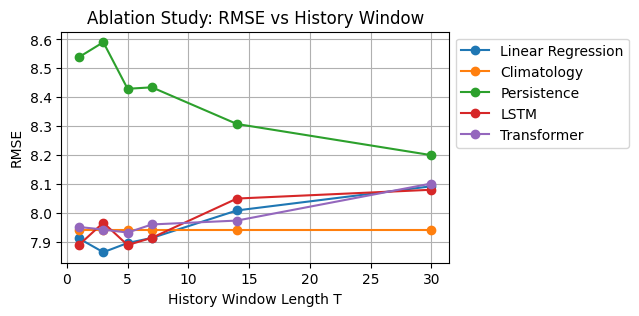

In [9]:
# Plot RMSE scores against history windows
plt.figure(figsize=(5,3))
plt.plot(df["T"], df["LR_RMSE"], "-o", label="Linear Regression")
plt.plot(df["T"], df["Clim_RMSE"], "-o", label="Climatology")
plt.plot(df["T"], df["Pers_RMSE"], "-o", label="Persistence")
plt.plot(df["T"], df["LSTM_RMSE"], "-o", label="LSTM")
plt.plot(df["T"], df["TRANS_RMSE"], "-o", label="Transformer")
plt.xlabel("History Window Length T")
plt.ylabel("RMSE")
plt.title("Ablation Study: RMSE vs History Window")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

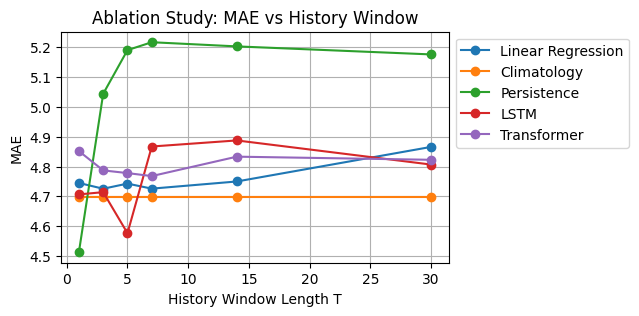

In [10]:
# Plot MSE scores against history windows
plt.figure(figsize=(5,3))
plt.plot(df["T"], df["LR_MAE"], "-o", label="Linear Regression")
plt.plot(df["T"], df["Clim_MAE"], "-o", label="Climatology")
plt.plot(df["T"], df["Pers_MAE"], "-o", label="Persistence")
plt.plot(df["T"], df["LSTM_MAE"], "-o", label="LSTM")
plt.plot(df["T"], df["TRANS_MAE"], "-o", label="Transformer")
plt.xlabel("History Window Length T")
plt.ylabel("MAE")
plt.title("Ablation Study: MAE vs History Window")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

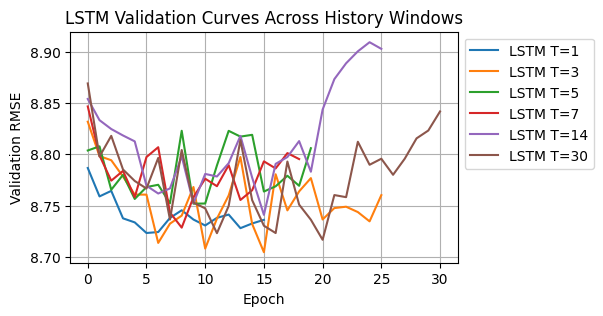

In [13]:
# Plot LSTM validation curves
plt.figure(figsize=(5,3))
for T in T_values:
    curve_file = f"{output_dir}/training_curves_T{T}.json"
    with open(curve_file, "r") as f:
        c = json.load(f)
    plt.plot(c["lstm_val"], label=f"LSTM T={T}")
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("LSTM Validation Curves Across History Windows")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

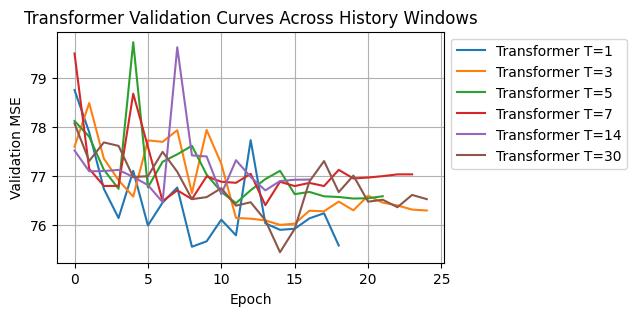

In [14]:
# Plot Transformer validation curves
plt.figure(figsize=(5,3))
for T in T_values:
    curve_file = f"{output_dir}/training_curves_T{T}.json"
    with open(curve_file, "r") as f:
        c = json.load(f)
    plt.plot(c["transformer_val"], label=f"Transformer T={T}")
plt.xlabel("Epoch")
plt.ylabel("Validation MSE")
plt.title("Transformer Validation Curves Across History Windows")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()